In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[toy_text]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3132 sha256=39d732548ef279500e81e7da8c78023f6fa218781134821d392880d3c9de92f1
  Stored in directory: /root/.cache/pip/wheels/f1/0a/2a/86955ea711b461ab7918236fed2568733f75ed677d0524b56c
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 6.9 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=48e09e545067d4d0285db58d45e6358dac5bd4a5302d4e73c354dfe28ed6c918
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2

In [ ]:
# Setup Environment
import gym
from colabgymrender.recorder import Recorder
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
from tqdm import tqdm
import os 
import numpy.ma as ma
from numpy.core.getlimits import inf
from collections import defaultdict
from gym.spaces import Space, Discrete
import random 
os.environ["SDL_VIDEODRIVER"] = "dummy"

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3629056/45929032 bytes (7.9%)7823360/45929032 bytes (17.0%)11935744/45929032 bytes (26.0%)16097280/45929032 bytes (35.0%)20201472/45929032 bytes (44.0%)24256512/45929032 bytes (52.8%)28278784/45929032 bytes (61.6%)32145408/45929032 bytes (70.0%)34996224/45929032 bytes (76.2%)37371904/45929032 bytes (81.4%)40378368/45929032 bytes (87.9%)43597824/45929032 bytes (94.9%)

In [ ]:
class Agent(object):
  def __init__(self, observation_space: Space, action_space: Space, alpha:float, epsilon: bool, training:bool):
    self._observiation_space = observation_space
    self._action_space = action_space
    self._training = training
    self._alpha = alpha
    self._prev_action = None
    self._prev_observation = None
    self._epsilon = epsilon

  def take_action(self, observation):
    pass
  

class BanditAgent(Agent):
  '''
  Multi-arm Bandit Agent.
  '''
  def __init__(self, observation_space: Discrete, action_space: Discrete, alpha:float, epsilon: bool, training: bool, initial_value:float):
    super().__init__(observation_space, action_space, alpha, epsilon, training)

    self._action_values = np.array([initial_value] * action_space.n) 

  def take_action(self, observation: int, prev_reward: int, action_mask: Optional[np.array] = None) -> int:
    # sample from action space
    ## todo: add expsilon-greedy
    masked_action_values = self._action_values
    if action_mask is not None:
      masked_action_values = ma.masked_array(self._action_values, 1 - action_mask)
    action = np.argmax(masked_action_values)
    
    if not self._training:
      return action
    
    # update action values: incremental implementation
    if self._prev_action is not None:
      prev_action_value = self._action_values[self._prev_action]
      self._action_values[self._prev_action] += self._alpha * (prev_reward - prev_action_value)

    self._prev_action = action
    return action

class ContextualBanditAgent(Agent):
  '''
  Multi-arm Contextual Bandit Agent.
  '''
  def __init__(self, observation_space: Discrete, action_space: Discrete, alpha:float, epsilon: bool, training: bool, initial_value:float):
    super().__init__(observation_space, action_space, alpha, epsilon, training)
    
    self._action_values = np.full((observation_space.n, action_space.n), initial_value)

  def update_action_values(self, prev_reward: float):
    # update action values: incremental implementation
      prev_action_value = self._action_values[self._prev_observation][self._prev_action]
      self._action_values[self._prev_observation][self._prev_action] += self._alpha * (prev_reward - prev_action_value)

  def take_action(self, observation: int, prev_reward: int, action_mask: Optional[np.array] = None) -> int:
    # sample from action space
    masked_action_values = self._action_values[observation]
    if random.random() < self._epsilon:
      if action_mask is not None:
        action = random.choice(np.where(action_mask == 1))
      else:
        action = random.choice(list(range(0, self._action_space.n)))
    else:
      if action_mask is not None:
        masked_action_values = ma.masked_array(masked_action_values, 1 - action_mask)
      max_value = np.max(masked_action_values)
      action = random.choice(np.where(masked_action_values == max_value)[0]) # Random break tie
    
    if not self._training:
      return action

    if self._prev_action is not None:
      self.update_action_values(prev_reward)

    self._prev_action = action
    self._prev_observation = observation
    return action

def test_bandit_agent():
  agent = BanditAgent(observation_space=Discrete(4), action_space=Discrete(5), alpha=0.5, epsilon=0, training=True, initial_value=5.0)
  assert agent._action_values.shape == (5,), f"{agent._action_values.shape} not correct"
  agent._prev_action = 1
  action = agent.take_action(observation = 1, prev_reward = 10, action_mask=np.array([0,0,1,0,0]))
  assert action == 2, 'Wrong greedy action selected'
  assert agent._action_values[1] == 7.5, f'Wrong action avalue update: {agent._action_values[1]}'
  print("bandit agent pass test.")

def test_contexual_bandit_agent():
  agent = ContextualBanditAgent(observation_space=Discrete(4), action_space=Discrete(5), alpha=0.5, epsilon=0, training=True, initial_value=5.0)
  assert agent._action_values.shape == (4,5), f"{agent._action_values.shape} not correct"
  agent._prev_observation = 2
  agent._prev_action = 1
  action = agent.take_action(observation = 1, prev_reward = 10, action_mask=np.array([0,0,1,1,0]))
  assert isinstance(action, np.int64), "Wrong action data type"
  assert (action == 2) or (action == 3), 'Wrong greedy action selected'
  assert agent._action_values[2][1] == 7.5, f'Wrong action avalue update: {agent._action_values[2][1]}'
  print("contextual bandit agent pass test.")

test_bandit_agent()
test_contexual_bandit_agent()



bandit agent pass test.
contextual bandit agent pass test.


In [ ]:
def train_agent(env, agent, epoch):
  reward_list=[]
  for i in tqdm(range(epoch), 'training steps: '):
    observation = env.reset()
    terminal = False
    reward = 0
    total_reward = 0
    action_mask = None
    while not terminal:
      action = agent.take_action(observation, reward, action_mask)
      observation, reward, terminal, info = env.step(action)
      total_reward += reward 
    # update with final reward at terminal
    agent.update_action_values(reward) 
    reward_list.append(total_reward)
  return reward_list

In [ ]:
# Create Environment.
#env = gym.make('Taxi-v3')
env = gym.make('CliffWalking-v0')
directory = './video'
env = Recorder(env, directory)
# Create Agent.
agent = ContextualBanditAgent(
    observation_space=env.observation_space, 
    action_space=env.action_space, 
    alpha=1, 
    epsilon=0.05, 
    training=True, 
    initial_value=5.0
)
epoch = 500
reward_list = train_agent(env, agent, epoch)

  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

training steps: 100%|██████████| 500/500 [11:41<00:00,  1.40s/it]


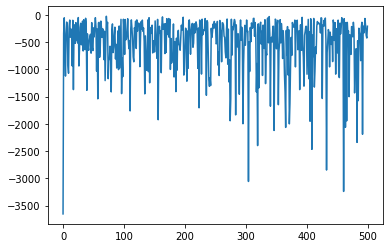

In [ ]:
import matplotlib.pyplot as plt
plt.plot(reward_list)

In [ ]:
# Play the last episode
env.play()

  result = np.fromstring(s, dtype='uint8')



action values of going to the right:  [[  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]
 [  -1.    5.    5.    5.    5.    5.    5.    5.    5.    5.    5.    5.]]


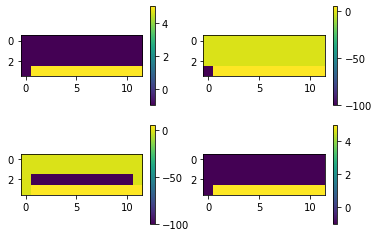

In [ ]:
# Plot the action values.
action_values = agent._action_values.reshape(4,12,4)
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')

print("action values of going to the right: ", action_values[:,:,2])

# Summary

## Bandit
Bandit doeesn't distinguish between siutations, making it only suitable for learning actions with on situations.

## Contexual Bandit

Contextual bandit is able to map situation to actions. However as shown by the cliff walking example, contextual bandit makes the assumption about the **problem** that action only affect immediate reward, but not the future rewards. 

Due to this assumption, contextual bandit only learn from immediate reward, not the future ones, making it unsuitable to solve the cliff walking problem. 

The steady state of the action values will be -1 unless the action leads to going off the cliff. (on the cliff, the values are -1 for up, right, left and -100 for down). This helps the agent to stay away from the cliff but doesn't maximize the total reward by reaching the goal faster. 

In order to learn from future reward, the agent needs to learn from the sum of the rewards of the entire episode, rather then immediate reward. This leads to DP, Monte Carlo method or TD. 

